In [3]:
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [4]:
#I have written several functions to do the analysis.

In [5]:
final_table = pd.read_csv('2.0_ultimate_final_frame.csv')

In [6]:
def Frame_Preparation(state, control_states, response, policy_change_year):
    #This function does the initial preparation of the frames and variables for analysis of the states
    #separate out into State and control frames
    control_state_frame = final_table.loc[(final_table['State'] == control_states[0]) | (final_table['State'] == control_states[1]) | (final_table['State'] == control_states[2])]
    response_state_frame = final_table.loc[final_table['State'] == state]
    
    #Pool by average of the counties
    control_pooled = control_state_frame.groupby('Year').mean()
    response_state_pooled = response_state_frame.groupby('Year').mean()
    control_pooled.reset_index(inplace = True)
    response_state_pooled.reset_index(inplace = True)
    
    #figure out policy change year
    pc_year = policy_change_year
    pc_year_minus_1 = pc_year -1
    
    #Calculate years from policy change
    control_pooled['Years_From_Policy_Change'] = control_pooled['Year'] - pc_year
    response_state_pooled['Years_From_Policy_Change'] = response_state_pooled['Year'] - pc_year
    
    return control_pooled, response_state_pooled, pc_year, pc_year_minus_1

In [7]:
def diff_in_diff(state, control_states, response, policy_change_year):
    #this function should give the diff_in_diff graph based on the state wanted
    #the control states as a list
    #the response column requested
    #and the policy change year
    
    control_pooled, response_state_pooled, pc_year, pc_year_minus_1 = Frame_Preparation(state, control_states, response, policy_change_year)
    
    plt.figure(figsize=(10,6))
    sns.lineplot(response_state_pooled[response_state_pooled['Year']<=pc_year_minus_1]['Years_From_Policy_Change'],response_state_pooled[response],color="green",label = state)
    sns.lineplot(response_state_pooled[response_state_pooled['Year']>pc_year_minus_1]['Years_From_Policy_Change'],response_state_pooled[response],color="green")
    sns.lineplot(control_pooled[control_pooled['Year']<=pc_year_minus_1]['Years_From_Policy_Change'],control_pooled[response],color="blue",label = 'Controls')
    sns.lineplot(control_pooled[control_pooled['Year']>pc_year_minus_1]['Years_From_Policy_Change'], control_pooled[response],color="blue")
    plt.axvline(x=0,linestyle = '-.',color = 'black')
    plt.xlabel("Years from Policy Change",fontsize = 12)
    plt.ylabel(response,fontsize = 12)
    plt.title("Difference in Difference Model Between " + state +' and Control States ' + control_states[0] + ', ' + control_states[1] + ' and ' + control_states[2],fontsize = 16)
    plt.show()

In [8]:
def Pre_Post(state, control_states, response, policy_change_year):
    #The control_states are required to prevent an error, but are not actually used in the analysis
    #This function will give the pre post analysis graph based on the response state (string) (two letter state form)
    #a list of control states strings, in two letter form (ex. ['GA', 'FL', 'AL'])
    #the reponse variable column as astring
    #and the policy change year as an integer
    
    control_pooled, response_state_pooled, pc_year, pc_year_minus_1 = Frame_Preparation(state, control_states, response, policy_change_year)
    
    plt.figure(figsize=(10,6))
    sns.lineplot(response_state_pooled[response_state_pooled['Year']<=pc_year_minus_1]['Years_From_Policy_Change'],response_state_pooled[response],color="green",label = 'pre')
    sns.lineplot(response_state_pooled[response_state_pooled['Year']>pc_year_minus_1]['Years_From_Policy_Change'],response_state_pooled[response],color="blue",label = 'post')
    plt.axvline(x=0,linestyle = '-.',color = 'black')
    plt.xlabel("Years from Policy Change",fontsize = 12)
    plt.ylabel(response,fontsize = 12)
    plt.title("Pre-Post Model Graph for " + state,fontsize = 16)
    plt.show()

In [58]:
def LinearRegressionDeathsPC(state, control_states, response, policy_change_year):
    #This is a function to carry out a linear regression for analysis
    #inputs are the same as the other functions
    
    all_state = final_table.loc[(final_table['State'] == control_states[0]) | (final_table['State'] == control_states[1]) | (final_table['State'] == control_states[2])| (final_table['State'] == state)]
    
        #figure out policy change year
    pc_year = policy_change_year
    pc_year_minus_1 = pc_year -1
    
    #Calculate years from policy change
    all_state['Years_From_Policy_Change'] = all_state['Year'] - pc_year
    
    #Create a variable of either before or after law year
    all_state['After_Policy_Change'] = [1 if x >= 0 else 0 for x in all_state['Years_From_Policy_Change']]

    #Create a variable of either control or state
    all_state['Control_or_Experimental'] = [0 if x == 'Control' else 1 for x in all_state['Year_Changed']]
    
    #Creat a concatenated string to represent each county
    
    all_state['State_County'] = all_state['State'] + all_state['County']
    
    #Create a variable of interaction between control and before or after law
    
    all_state['Policy_Change_And_Experimental_State'] = all_state['After_Policy_Change'] + all_state['Control_or_Experimental']
    all_state['Policy_Change_And_Experimental_State'] = [1 if x == 2 else 0 for x in all_state['Policy_Change_And_Experimental_State']]
    
    #Run the regression
    #panel_data = data.set_index(['County', 'Year'])
    linear_regression = smf.ols('Deaths_PC ~ C(After_Policy_Change) + C(Policy_Change_And_Experimental_State) + C(State_County)', data = all_state).fit()
        
    
    #Show the regression
    print(linear_regression.summary())

In [62]:
def LinearRegressionMorphPC(state, control_states, response, policy_change_year):
    #This is a function to carry out a linear regression for analysis
    #inputs are the same as the other functions
    
    all_state = final_table.loc[(final_table['State'] == control_states[0]) | (final_table['State'] == control_states[1]) | (final_table['State'] == control_states[2])| (final_table['State'] == state)]
    all_state = all_state.loc[(all_state['Year'] >= 2006) & (all_state['Year'] < 2013)]
    
        #figure out policy change year
    pc_year = policy_change_year
    pc_year_minus_1 = pc_year -1
    
    #Calculate years from policy change
    all_state['Years_From_Policy_Change'] = all_state['Year'] - pc_year
    
    #Create a variable of either before or after law year
    all_state['After_Policy_Change'] = [1 if x >= 0 else 0 for x in all_state['Years_From_Policy_Change']]

    #Create a variable of either control or state
    all_state['Control_or_Experimental'] = [0 if x == 'Control' else 1 for x in all_state['Year_Changed']]
    
    #Creat a concatenated string to represent each county
    
    all_state['State_County'] = all_state['State'] + all_state['County']
    
    #Create a variable of interaction between control and before or after law
    
    all_state['Policy_Change_And_Experimental_State'] = all_state['After_Policy_Change'] + all_state['Control_or_Experimental']
    all_state['Policy_Change_And_Experimental_State'] = [1 if x == 2 else 0 for x in all_state['Policy_Change_And_Experimental_State']]
    
    #Run the regression
    #panel_data = data.set_index(['County', 'Year'])
    linear_regression = smf.ols('Morphine_Equivalents_PC ~ C(After_Policy_Change) + C(Policy_Change_And_Experimental_State) + C(State_County)', data = all_state).fit()
        
    
    #Show the regression
    print(linear_regression.summary())

In [63]:
LinearRegressionMorphPC('FL',['GA','AL','NC'],'Morphine_Equivalents_PC', 2010)

                               OLS Regression Results                              
Dep. Variable:     Morphine_Equivalents_PC   R-squared:                       0.970
Model:                                 OLS   Adj. R-squared:                  0.962
Method:                      Least Squares   F-statistic:                     126.0
Date:                     Mon, 25 Nov 2019   Prob (F-statistic):               0.00
Time:                             17:32:59   Log-Likelihood:                 529.64
No. Observations:                     1673   AIC:                            -383.3
Df Residuals:                         1335   BIC:                             1449.
Df Model:                              337                                         
Covariance Type:                 nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [61]:
LinearRegressionDeathsPC('FL',['GA','AL','NC'],'Deaths_PC', 2010)

C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

                            OLS Regression Results                            
Dep. Variable:              Deaths_PC   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     20.41
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          2.10e-236
Time:                        17:29:03   Log-Likelihood:                 11432.
No. Observations:                1289   AIC:                        -2.256e+04
Df Residuals:                    1136   BIC:                        -2.177e+04
Df Model:                         152                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [60]:
LinearRegressionDeathsPC('WA',['ID','OR','MT'],'Deaths_PC',2012)

                            OLS Regression Results                            
Dep. Variable:              Deaths_PC   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     16.41
Date:                Mon, 25 Nov 2019   Prob (F-statistic):           1.62e-52
Time:                        17:27:37   Log-Likelihood:                 2983.8
No. Observations:                 331   AIC:                            -5890.
Df Residuals:                     292   BIC:                            -5741.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [59]:
LinearRegressionDeathsPC('TX',['CA','NM','AZ'],'Deaths_PC', 2007)


C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\mayas\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

                            OLS Regression Results                            
Dep. Variable:              Deaths_PC   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     33.80
Date:                Mon, 25 Nov 2019   Prob (F-statistic):          3.43e-269
Time:                        17:24:35   Log-Likelihood:                 9705.5
No. Observations:                1088   AIC:                        -1.918e+04
Df Residuals:                     971   BIC:                        -1.859e+04
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [17]:
final_table.head(2)

,Unnamed: 0,index,State,County,Year,Deaths,Year_Changed,Population,Deaths_PC
0,2,2.0,AL,BALDWIN,2003.0,10.0,Control,151574.0,0.000066
1,3,3.0,AL,JEFFERSON,2003.0,69.0,Control,659191.0,0.000105


In [18]:
linear_regression = smf.ols('Deaths_PC ~ C(Year) + State + Population', data = final_table).fit()
print(linear_regression.summary())

                            OLS Regression Results                            
Dep. Variable:              Deaths_PC   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     32.27
Date:                Fri, 22 Nov 2019   Prob (F-statistic):          6.78e-129
Time:                        14:41:35   Log-Likelihood:                 20999.
No. Observations:                2728   AIC:                        -4.195e+04
Df Residuals:                    2703   BIC:                        -4.180e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0001   1.26e-0

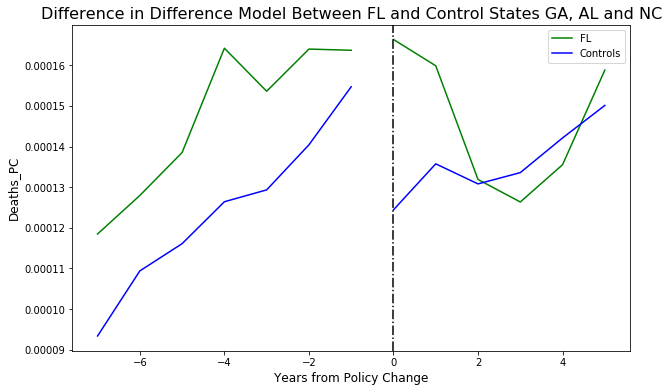

In [8]:
#Test if it works
diff_in_diff('FL', ['GA','AL','NC'], 'Deaths_PC', 2010)

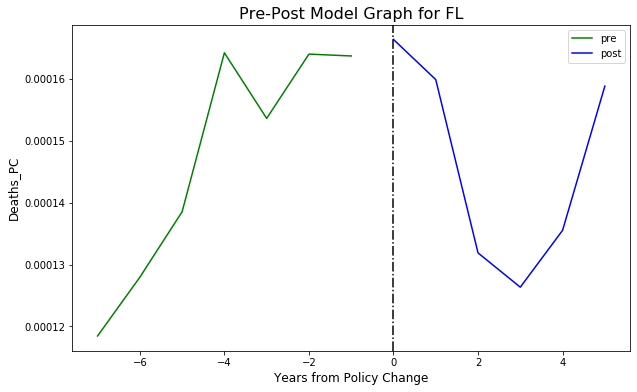

In [9]:
#Pre-Post for Florida
Pre_Post('FL', ['GA','AL','FL'], 'Deaths_PC', 2010)

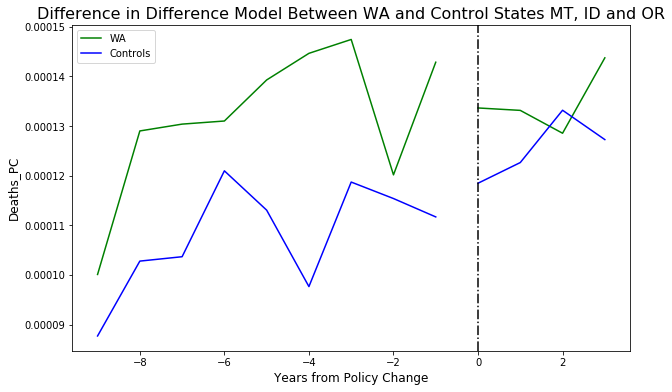

In [10]:
#Diff in Diff for Washington
diff_in_diff('WA', ['MT','ID','OR'], 'Deaths_PC', 2012)

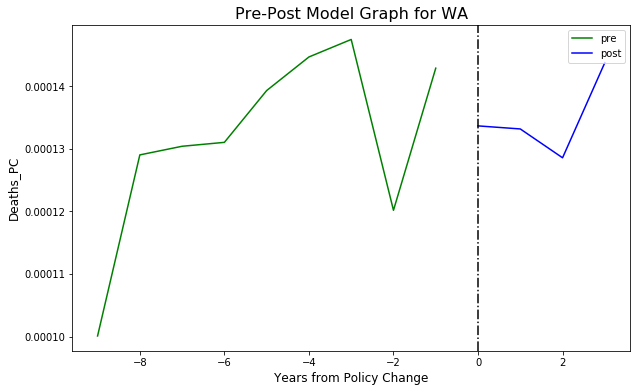

In [11]:
#Pre-Post for Washington
Pre_Post('WA', ['MT','OR','ID'], 'Deaths_PC', 2012)

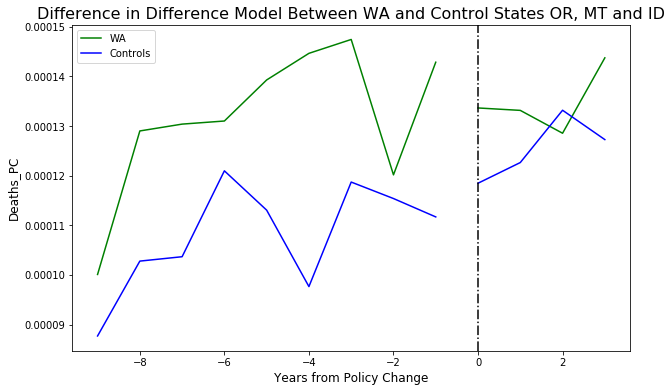

In [12]:
#diff in diff for washington
diff_in_diff('WA', ['OR','MT','ID'], 'Deaths_PC', 2012)

In [13]:
#Diff in Diff for FL Morphine Equivalents per capita
diff_in_diff('FL', ['GA','AL','NC'], 'Morphine_Equivalents_PC', 2010)

KeyError: 'Morphine_Equivalents_PC'

<Figure size 720x432 with 0 Axes>

In [ ]:
#Pre-Post for Florida Morphine Equivalents per capita
Pre_Post('FL', ['GA','AL','NC'], 'Morphine_Equivalents_PC', 2010)

In [ ]:
diff_in_diff('FL',['GA','AL','NC'],'Morphine_Equivalents_PC', 201)

In [ ]:
diff_in_diff('TX', ['CA','AZ','NM'], 'Deaths_PC', 2007)

In [ ]:
Pre_Post('TX', ['CA','AZ','NM'], 'Deaths_PC', 2007)